In [1]:
import os
import sys
from matplotlib import pyplot as plt
sys.path.append('Lab02_NMT')

import numpy as np
import pandas as pd
from tqdm import tqdm
import yaml
import json
import librosa
from librosa import display as ld
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader

from neural_network import NN_CATALOG
from dataset.bird_clef import load_wav
from dataset.augmentations import Normalize


Bad key text.latex.preview in file /home/cherepaha/miniconda/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/cherepaha/miniconda/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/cherepaha/miniconda/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # w

In [2]:
bird_tax = pd.read_csv('data/eBird_Taxonomy_v2021.csv', index_col=0)
train_meta = pd.read_csv('data/train_metadata_extended.csv')
with open('data/scored_birds.json') as fin:
    scored_birds = json.load(fin)

In [3]:
train_meta.loc[:, 'secondary_labels'] = train_meta.secondary_labels.apply(eval)
train_meta['target_raw'] = train_meta.secondary_labels + train_meta.primary_label.apply(lambda x: [x])

In [4]:
all_species = sorted(set(train_meta.target_raw.sum()))
species2id = {s: i for i, s in enumerate(all_species)}
id2species = {i: s for i, s in enumerate(all_species)}

train_meta['target'] = train_meta.target_raw.apply(lambda species: [int(s in species) for s in all_species])

In [5]:
test_meta = train_meta[train_meta.duration > 60]

In [6]:
data_root = 'data/train_audio/'
test_fnames = test_meta.filename.values.tolist()

### Dataset

In [7]:
class TestDataset(Dataset):
    def __init__(self, data_root, fnames, augmentations=None):
        super().__init__()
        self.data_root = data_root
        self.fnames = fnames
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        fpath = os.path.join(self.data_root, self.fnames[idx])
        wav, sr = load_wav(fpath, 0, 60)
        if self.augmentations:
            wav = self.augmentations(wav, None)
        wav = torch.tensor(wav)      
        assert (13 * 5 * sr) > len(wav) 
        wav = wav[:len(wav) // 12 * 12].reshape((12, len(wav) // 12))
        return wav

In [8]:
test_dataset = TestDataset(
    data_root,
    test_fnames, 
    augmentations=Normalize(p=1)
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    drop_last=False,   
)

<AxesSubplot:>

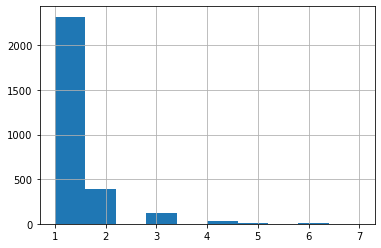

In [9]:
test_meta.target.apply(sum).hist()

### Model

In [13]:
config_path = 'Lab02_NMT/configs/baseline_config.yaml'
model_path = 'Lab02_NMT/model_save/baseline_39wbtt2e/final-model.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open(config_path) as fin:
    config = yaml.safe_load(fin)

model_config = config['model']
if 'backbone_config' in model_config['params']:
    model_config['params']['backbone_config']['pretrained'] = False
data_config = config['data']
model_class = NN_CATALOG[model_config['name']]

model = model_class(len(all_species), int(data_config['crop_len'] // data_config['test_wav_len']),
                    **model_config['params'])
model.to(device)

state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [14]:
test_birds = list(set(test_meta.target_raw.sum()))
test_birds = sorted(test_birds)

In [15]:
pred_list = []
treshold = 0.1
model.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_dataloader)):
        batch_size, part_count, part_size = batch.shape
        batch = batch.reshape(batch_size * part_count, part_size)
        pred = model(batch.to(device))['logits']
        pred = pred.cpu().numpy()
#         pred = pred > treshold
        
        for j, chunk_pred in enumerate(pred):
            inbatch_number = j // part_count
            chunk_number = j % part_count + 1
            f_idx = i * batch_size + inbatch_number
            
            fname = test_dataset.fnames[f_idx]
            
            pred_list.extend([{
                'filename': fname,
                'right': 5 * chunk_number,
                'left': 5 * chunk_number - 5,
                'bird': b,
                'pred': chunk_pred[species2id[b]]
            } for b in test_birds])
pred_pd = pd.DataFrame(pred_list)

0it [00:00, ?it/s]/home/cherepaha/miniconda/envs/py37/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/cherepaha/miniconda/envs/py37/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)
2885it [01:05, 43.97it/s]


In [16]:
pred_pd.to_csv('eff_pred.csv', index=False)

['apapan', 'iiwi', 'warwhe1', 'akepa1']
['afrsil1' 'akekee' 'akepa1' 'akiapo' 'amewig' 'aniani' 'apapan' 'arcter'
 'barpet' 'bcnher' 'belkin1' 'bkbplo' 'bknsti' 'bkwpet' 'blkfra' 'blknod'
 'bongul' 'brant' 'brnboo' 'brnowl' 'brtcur' 'buffle' 'bulpet' 'burpar'
 'buwtea' 'cacgoo1' 'calqua' 'cangoo' 'canvas' 'caster1' 'categr' 'chukar'
 'cintea' 'comgal1' 'commyn' 'compea' 'comsan' 'comwax' 'crehon' 'dunlin'
 'elepai' 'eurwig' 'fragul' 'gadwal' 'gamqua' 'glwgul' 'gnwtea' 'golphe'
 'grbher3' 'grefri' 'gresca' 'gryfra' 'gwfgoo' 'hawama' 'hawcre' 'hawhaw'
 'hawpet1' 'hoomer' 'houfin' 'houspa' 'hudgod' 'iiwi' 'incter1' 'jabwar'
 'japqua' 'kalphe' 'laugul' 'lcspet' 'leasan' 'leater1' 'lessca' 'lesyel'
 'lobdow' 'lotjae' 'madpet' 'magpet1' 'mallar3' 'maupar' 'merlin' 'mitpar'
 'moudov' 'norcar' 'norhar2' 'normoc' 'norpin' 'norsho' 'nutman' 'oahama'
 'omao' 'osprey' 'pagplo' 'parjae' 'pecsan' 'peflov' 'perfal' 'pibgre'
 'pomjae' 'reccar' 'redava' 'redjun' 'redpha1' 'refboo' 'rempar' 'rettro'
 'r

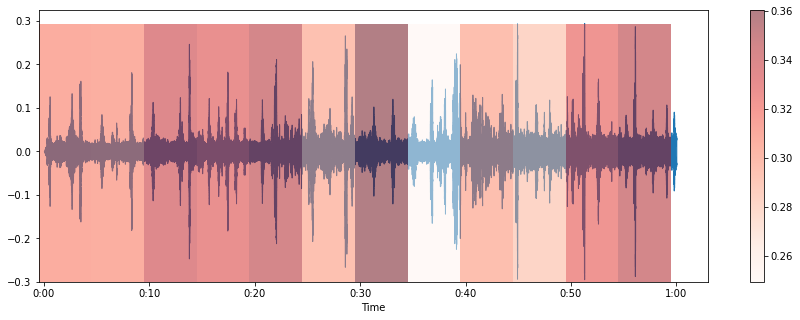

In [138]:
idx = 4
fig, ax = plt.subplots(figsize=(15, 5))
fname = test_meta.iloc[idx]['filename']
fpath = os.path.join('data/train_audio/', fname)
wav, sr = load_wav(fpath, 0, 60)
ld.waveshow(wav, sr=sr, ax=ax)

sample_pred = pred_pd[(pred_pd.filename == fname) & (pred_pd.pred)]
sample_birds = sample_pred.bird.unique()
bird_to_plot = test_meta.iloc[idx]['target_raw'][2]
bird_pred = sample_pred[sample_pred.bird == bird_to_plot]
# bird_pred.loc[:, 'right'] = bird_pred.right * sr
# bird_pred.loc[:, 'left'] = bird_pred.left * sr

# for i, row in bird_pred.iterrows():
#     ax.fill_betweenx(
#         [wav.min(), wav.max()],
#         row.left, row.right,
#         alpha=0.3,
#         color='orange',
#         edgecolor="none"
#     )

nx = 60
x = np.linspace(0,nx-1,nx)
y = np.linspace(wav.min(), wav.max(), 50)
X,Y = np.meshgrid(x, y, indexing='ij')
Z = X * 0 # set a fancy Z function

for i, row in bird_pred.iterrows():
    Z[row.left:row.right, :] = row.pred

# fig = plt.figure(figsize=(22,11)) 
# ax1 = fig.add_subplot(121)
pc = ax.pcolormesh(X, Y, Z, edgecolors='none',cmap="Reds", alpha=0.5)
fig.colorbar(pc)
print(test_meta.iloc[idx]['target_raw'])
print(sample_birds)

['apapan', 'iiwi', 'warwhe1', 'akepa1']
['afrsil1' 'akekee' 'akepa1' 'akiapo' 'amewig' 'aniani' 'apapan' 'arcter'
 'barpet' 'bcnher' 'belkin1' 'bkbplo' 'bknsti' 'bkwpet' 'blkfra' 'blknod'
 'bongul' 'brant' 'brnboo' 'brnowl' 'brtcur' 'buffle' 'bulpet' 'burpar'
 'buwtea' 'cacgoo1' 'calqua' 'cangoo' 'canvas' 'caster1' 'categr' 'chukar'
 'cintea' 'comgal1' 'commyn' 'compea' 'comsan' 'comwax' 'crehon' 'dunlin'
 'elepai' 'eurwig' 'fragul' 'gadwal' 'gamqua' 'glwgul' 'gnwtea' 'golphe'
 'grbher3' 'grefri' 'gresca' 'gryfra' 'gwfgoo' 'hawama' 'hawcre' 'hawhaw'
 'hawpet1' 'hoomer' 'houfin' 'houspa' 'hudgod' 'iiwi' 'incter1' 'jabwar'
 'japqua' 'kalphe' 'laugul' 'lcspet' 'leasan' 'leater1' 'lessca' 'lesyel'
 'lobdow' 'lotjae' 'madpet' 'magpet1' 'mallar3' 'maupar' 'merlin' 'mitpar'
 'moudov' 'norcar' 'norhar2' 'normoc' 'norpin' 'norsho' 'nutman' 'oahama'
 'omao' 'osprey' 'pagplo' 'parjae' 'pecsan' 'peflov' 'perfal' 'pibgre'
 'pomjae' 'reccar' 'redava' 'redjun' 'redpha1' 'refboo' 'rempar' 'rettro'
 'r

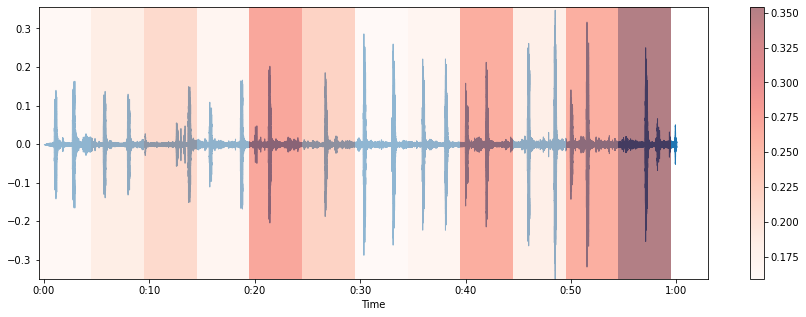

In [18]:
idx = 5
fig, ax = plt.subplots(figsize=(15, 5))
fname = test_meta.iloc[idx]['filename']
fpath = os.path.join('data/train_audio/', fname)
wav, sr = load_wav(fpath, 0, 60)
ld.waveshow(wav, sr=sr, ax=ax)

sample_pred = pred_pd[(pred_pd.filename == fname) & (pred_pd.pred)]
sample_birds = sample_pred.bird.unique()
bird_to_plot = test_meta.iloc[idx]['target_raw'][2]
bird_pred = sample_pred[sample_pred.bird == bird_to_plot]
# bird_pred.loc[:, 'right'] = bird_pred.right * sr
# bird_pred.loc[:, 'left'] = bird_pred.left * sr

# for i, row in bird_pred.iterrows():
#     ax.fill_betweenx(
#         [wav.min(), wav.max()],
#         row.left, row.right,
#         alpha=0.3,
#         color='orange',
#         edgecolor="none"
#     )

nx = 60
x = np.linspace(0,nx-1,nx)
y = np.linspace(wav.min(), wav.max(), 50)
X,Y = np.meshgrid(x, y, indexing='ij')
Z = X * 0 # set a fancy Z function

for i, row in bird_pred.iterrows():
    Z[row.left:row.right, :] = row.pred

# fig = plt.figure(figsize=(22,11)) 
# ax1 = fig.add_subplot(121)
pc = ax.pcolormesh(X, Y, Z, edgecolors='none',cmap="Reds", alpha=0.5)
fig.colorbar(pc)
print(test_meta.iloc[idx]['target_raw'])
print(sample_birds)

In [19]:
per_wav_stat = pred_pd.groupby(['filename', 'bird']).agg(
    mean=('pred', np.mean),
    std=('pred', np.std),
).reset_index()

per_wav_stat['rank'] = per_wav_stat.groupby('filename')['mean'].rank(ascending=False)

In [20]:
per_wav_stat = per_wav_stat.merge(test_meta[['filename', 'target_raw']], on='filename')
gt_stat = per_wav_stat[per_wav_stat.apply(lambda x: x.bird in x.target_raw, axis=1)]

In [21]:
per_bird_stat = gt_stat.groupby('bird').agg(
    mean=('mean', np.mean),
    std=('std', np.mean),
    rank=('rank', np.mean),
    f_count=('filename', 'count')
)

In [22]:
per_bird_stat.to_csv('eff_stat.csv', index=True)

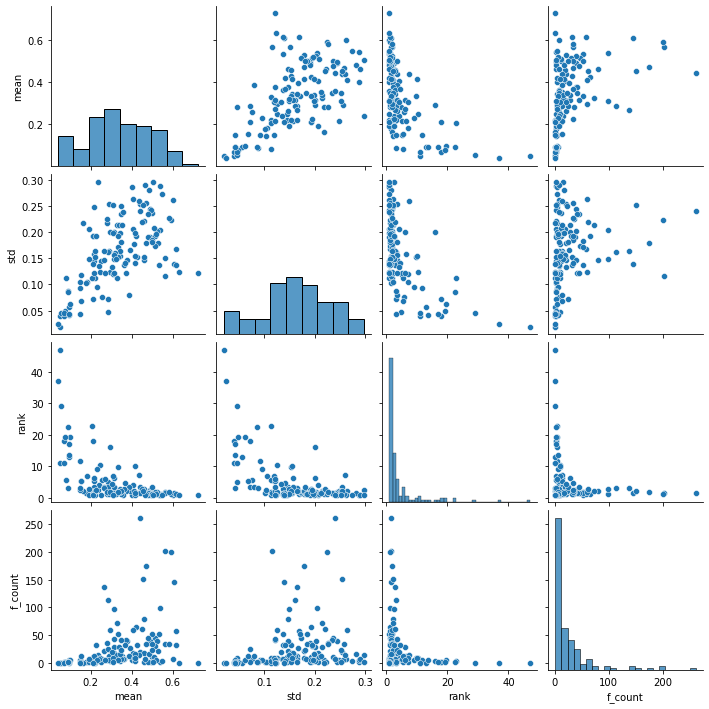

In [23]:
sns.pairplot(per_bird_stat)

In [26]:
!ls

ActivationStudy.ipynb  data2021        maxpool_pred.csv
baseline_pred.csv      eff_pred.csv    maxpool_stat.csv
baseline_stat.csv      eff_stat.csv    StatStudy.ipynb
birdclef-2022.zip      focal_pred.csv  submit
birdclef.ipynb	       focal_stat.csv  Untitled.ipynb
birdclef-submit.ipynb  Lab02_NMT
data		       Lab02_NMT.zip


In [27]:
stat_dict = {
    model: pd.read_csv(f'{model}_stat.csv', index_col=0) for model in ['maxpool', 'focal', 'baseline', 'eff']
}

In [28]:
global_target = np.array([t for t in train_meta.target])
bird_ratio = global_target.mean(axis=0)

In [30]:
for model, stat in stat_dict.items():
    stat.reset_index(inplace=True)
    stat['proportion'] = stat.bird.apply(lambda x: bird_ratio[species2id[x]])
    stat.set_index('bird', inplace=True)
    stat['model'] = model

mean       std       rank  f_count  proportion    model
bird                                                                
afrsil1  0.000641  0.001376  42.000000        1    0.001077  maxpool
akekee   0.134846  0.214917   1.500000        2    0.000404  maxpool
akepa1   0.076107  0.035914   5.555556        9    0.000875  maxpool
akiapo   0.070648  0.053287   8.000000        8    0.001145  maxpool
amewig   0.199945  0.183996   3.363636       11    0.004377  maxpool
...           ...       ...        ...      ...         ...      ...
whttro   0.091122  0.086129  22.500000        2    0.001549      eff
wiltur   0.226920  0.193444   2.606061       33    0.005656      eff
yebcar   0.724870  0.120903   1.000000        1    0.001347      eff
yefcan   0.414569  0.153817  10.111111        9    0.004646      eff
zebdov   0.306356  0.133753   4.250000       20    0.008147      eff

[544 rows x 6 columns]

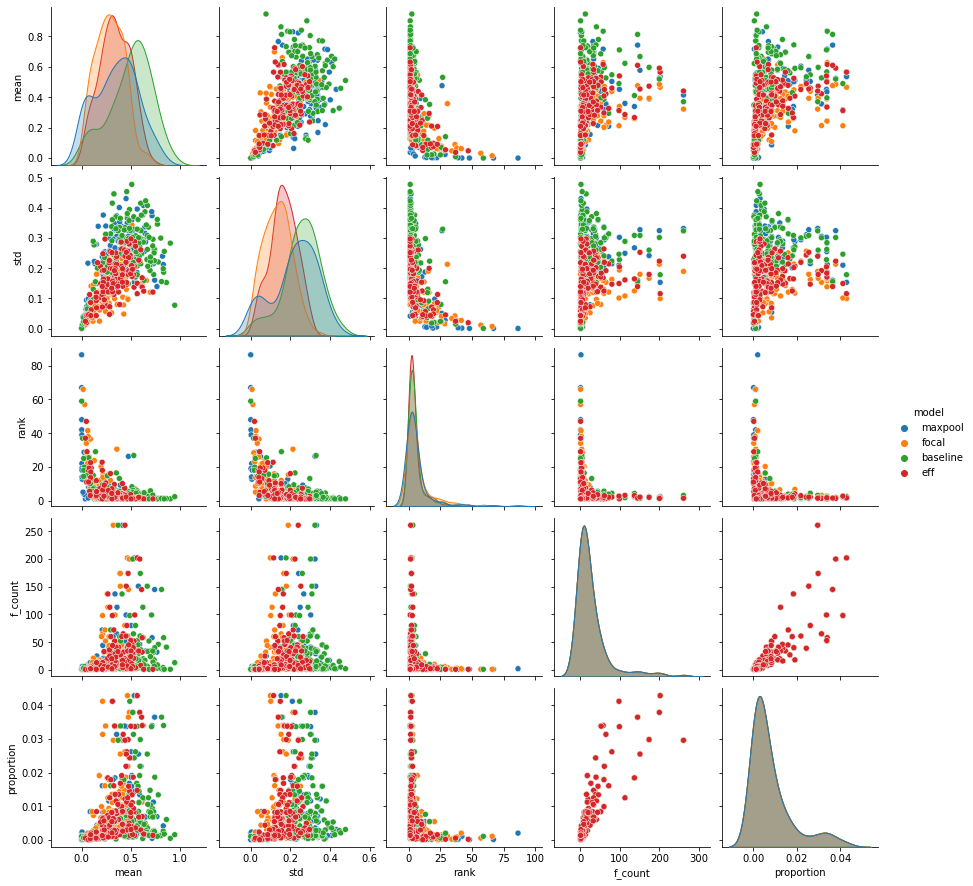

In [36]:
sns.pairplot(
    pd.concat(stat_dict.values()),
    hue='model',
)

In [37]:
pred_pd = pd.read_csv('eff_pred.csv')

In [40]:
(pred_pd.pred > 0.1).sum()

127819